## 1. Importing the Packages

In [53]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## 2. Defining Key Dates

In [54]:
start_date = "2009-04-05" # Starting Date

ann_1 = "2009-12-09" # First Official Announcement - 49.9%

ann_2 = "2012-07-05" # Second Official Announcement - 51.1%

end_date = "2014-01-01" #Ending Date

d_gate = '2015-09-20' # Dieselgate Case

## 3. Data

### 3.1. Importing 

In [55]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [56]:
df = raw_data.copy()

In [57]:
#summary of the data
print ("Row Number     : " , df.shape[0])
print ("Column Number  : " , df.shape[1])
print ("\nColumn Names: \n" , df.columns.tolist())
print ("\nMissing values:  ", df.isnull().sum().values.sum())

Row Number     :  6310
Column Number  :  15

Column Names: 
 [('PAH3.DE', 'Open'), ('PAH3.DE', 'High'), ('PAH3.DE', 'Low'), ('PAH3.DE', 'Close'), ('PAH3.DE', 'Volume'), ('BMW.DE', 'Open'), ('BMW.DE', 'High'), ('BMW.DE', 'Low'), ('BMW.DE', 'Close'), ('BMW.DE', 'Volume'), ('VOW3.DE', 'Open'), ('VOW3.DE', 'High'), ('VOW3.DE', 'Low'), ('VOW3.DE', 'Close'), ('VOW3.DE', 'Volume')]

Missing values:   18055


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6310 entries, 1996-11-08 to 2021-06-21
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (PAH3.DE, Open)    3144 non-null   float64
 1   (PAH3.DE, High)    3144 non-null   float64
 2   (PAH3.DE, Low)     3144 non-null   float64
 3   (PAH3.DE, Close)   3144 non-null   float64
 4   (PAH3.DE, Volume)  3144 non-null   float64
 5   (BMW.DE, Open)     6309 non-null   float64
 6   (BMW.DE, High)     6309 non-null   float64
 7   (BMW.DE, Low)      6309 non-null   float64
 8   (BMW.DE, Close)    6309 non-null   float64
 9   (BMW.DE, Volume)   6309 non-null   float64
 10  (VOW3.DE, Open)    5866 non-null   float64
 11  (VOW3.DE, High)    5866 non-null   float64
 12  (VOW3.DE, Low)     5866 non-null   float64
 13  (VOW3.DE, Close)   5866 non-null   float64
 14  (VOW3.DE, Volume)  5866 non-null   float64
dtypes: float64(15)
memory usage: 788.8 KB


In [59]:
df.describe()

PAH3.DE               ...      VOW3.DE              
              Open         High  ...        Close        Volume
count  3144.000000  3144.000000  ...  5866.000000  5.866000e+03
mean     44.409085    45.013567  ...    79.795453  8.574149e+05
std      13.815766    13.883175  ...    58.729078  1.015061e+06
min      17.697953    18.025803  ...    11.863153  0.000000e+00
25%      33.500976    34.057864  ...    19.737554  2.118992e+05
50%      44.451081    44.979459  ...    69.628613  6.723945e+05
75%      53.326504    53.871681  ...   132.671841  1.162164e+06
max     101.550003   102.000000  ...   246.550003  1.753497e+07

[8 rows x 15 columns]

### 3.2. Pre-processing

In [60]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [61]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [62]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

In [63]:
#summary of the data after pre-processing
print ("Row Number     : " , df.shape[0])
print ("Column Number  : " , df.shape[1])
print ("\nColumn Names: \n" , df.columns.tolist())
print ("\nMissing values:  ", df.isnull().sum().values.sum())

Row Number     :  6422
Column Number  :  12

Column Names: 
 [('vol', ''), ('por', ''), ('bmw', ''), ('ret_vol', ''), ('ret_por', ''), ('ret_bmw', ''), ('sq_vol', ''), ('sq_por', ''), ('sq_bmw', ''), ('q_vol', ''), ('q_por', ''), ('q_bmw', '')]

Missing values:   0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6422 entries, 1996-11-08 to 2021-06-21
Freq: B
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   (vol, )      6422 non-null   float64
 1   (por, )      6422 non-null   float64
 2   (bmw, )      6422 non-null   float64
 3   (ret_vol, )  6422 non-null   float64
 4   (ret_por, )  6422 non-null   float64
 5   (ret_bmw, )  6422 non-null   float64
 6   (sq_vol, )   6422 non-null   float64
 7   (sq_por, )   6422 non-null   float64
 8   (sq_bmw, )   6422 non-null   float64
 9   (q_vol, )    6422 non-null   float64
 10  (q_por, )    6422 non-null   float64
 11  (q_bmw, )    6422 non-null   float64
dtypes: float64(12)
memory usage: 652.2 KB


In [65]:
df.describe()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
count,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6422.000000,6.422000e+03,6.422000e+03,6.422000e+03
mean,77.363606,35.876439,37.076758,-0.249677,-1.864531,0.060026,6.811874,10.309866,4.710442,8.045297e+05,7.583063e+05,2.234881e+06
std,57.969149,13.108628,21.460123,2.598189,2.614279,2.169694,17.848239,13.922036,12.033881,9.952007e+05,3.547921e+05,1.497844e+06
min,11.863153,17.509737,9.998116,-19.818453,-17.875320,-13.185068,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,21.013208,27.132023,19.796148,-1.508123,-3.831334,-1.014695,0.306211,1.426349,0.207975,1.681735e+05,4.939598e+05,1.323396e+06
50%,58.589827,27.132023,25.919147,-0.087435,-3.831334,0.000000,1.711100,14.679119,1.099448,5.881120e+05,9.015660e+05,1.934134e+06
75%,130.394268,44.543437,59.032669,1.121942,0.000000,1.073771,6.914326,14.679119,4.181879,1.121512e+06,9.015660e+05,2.756822e+06
max,246.550003,101.199997,95.889999,19.688585,16.605060,14.838404,392.771083,319.527052,220.178234,1.753497e+07,5.944992e+06,2.871954e+07


## 4. Plotting the Prices

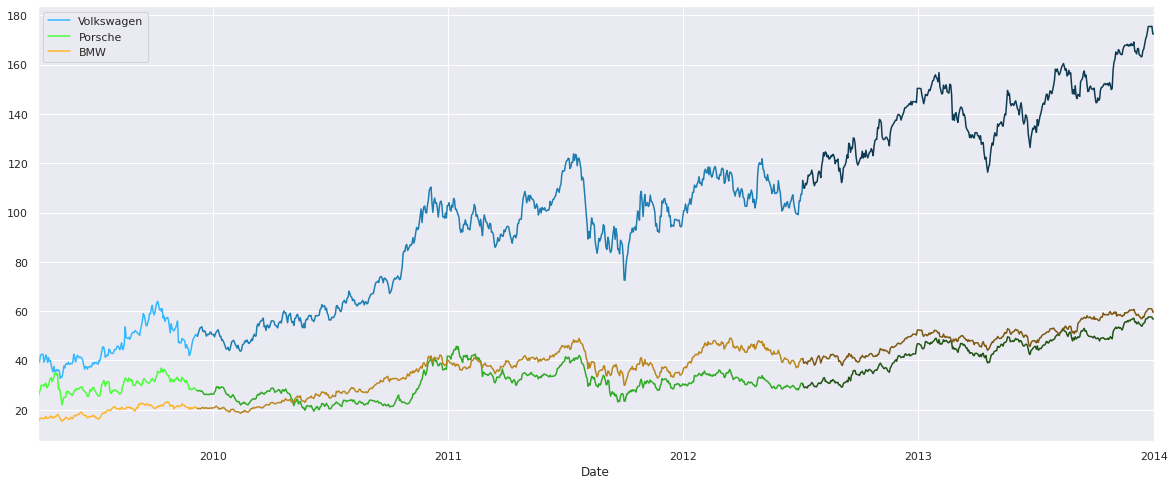

In [66]:
df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF") #blue
df['por'][start_date:ann_1].plot(color = "#49FF3A") #green
df['bmw'][start_date:ann_1].plot(color = "#FEB628") #gold

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2") #blue
df['por'][ann_1:ann_2].plot(color = "#2FAB25") #green
df['bmw'][ann_1:ann_2].plot(color = "#BA861F") #gold

df['vol'][ann_2:end_date].plot(color = "#0E3A52") #blue
df['por'][ann_2:end_date].plot(color = "#225414") #green
df['bmw'][ann_2:end_date].plot(color = "#7C5913") #gold

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

There is some similarity in the way they move, which indicates trends of the entire automobile industry market. However, VW prices shift a lot more in magnitude after the third quarter of 2009. To get a better idea of what's really happening, different intervals are separated by color. Prior to the first announcement(light colours), it is seen that VW and Porsche move in the same direction. However, Volkswagen's numbers seem to be roughly twice as high. Afterwards(dark colours), the gap between the two seems to grow bigger and bigger. If you look at BMW numbers, it is seen that they resemble the Porsche ones much closer than the VW ones. To get a better idea of how similar each one of these series is to the others, we should examine their correlation.

## 5. Correlation

### 5.1. Period Between Starting & Ending Dates

In [67]:
#only interested in the period between the starting and ending dates
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen(VW) and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen(VW) and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen(VW) and Porsche correlation: 	0.8359547164164515
Volkswagen(VW) and BMW correlation: 	0.9799378238685721
Porsche and BMW correlation: 		0.8052157864053252


Interestingly enough, there is a much higher correlation between VW and BMW prices than between VW and Porsche. This suggests that VW moves in a similar way to the market benchmark. However, VW owns 100% of Porsche by the end of this time interval. Therefore the correlation should be much higher. To understand what's really going on, three different intervals should be examined step by step, starting from the earliest one.

### 5.2. Period Between Starting Date & First Announcement

In [68]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen(VW) and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen(VW) and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen(VW) and Porsche correlation: 	0.6633584449543652
Volkswagen(VW) and BMW correlation: 	0.8427607522914173
Porsche and BMW correlation: 		0.6095038702477737


### 5.2. Period Between First & Second Announcement

In [69]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen(VW) and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen(VW) and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen(VW) and Porsche correlation: 	0.7428267849870892
Volkswagen(VW) and BMW correlation: 	0.9795942967234552
Porsche and BMW correlation: 		0.704272314192468


### 5.2. Period Between Second Announcement & Ending Date 

In [70]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen(VW) and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen(VW) and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen(VW) and Porsche correlation: 	0.9405237174785849
Volkswagen(VW) and BMW correlation: 	0.928444728215463
Porsche and BMW correlation: 		0.9494111768498266


### 5.2. Period Between Ending Date & Today

In [71]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen(VW) and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen(VW) and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2021-06-21 00:00:00

Volkswagen(VW) and Porsche correlation: 	0.9633319509137394
Volkswagen(VW) and BMW correlation: 	0.6376800417501762
Porsche and BMW correlation: 		0.6375213205101679


### 6. Best Fitting Models

### 6.1. For Volkswagen

In [72]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [73]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -327.180
Date:                Mon, 21 Jun 2021   AIC                            664.360
Time:                        18:20:20   BIC                            680.269
Sample:                    04-06-2009   HQIC                           670.811
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7404      0.458      1.618      0.106      -0.156       1.637
por            0.3997      0.096      4.168      0.000       0.212       0.588
bmw            0.7084      0.336      2.107      0.035       0.049       1.367
ar.L1          0.9633      0.020     48.669      0.000       0.925       1.002
sigma2         2.2785      0.155     14.717      0.000       1.975       2.582
===================================================================================
Ljung-Box (Q):                       38.24   Jarque-Bera (JB):               166.02
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1095.854
Date:                Mon, 21 Jun 2021   AIC                           2197.708
Time:                        18:20:20   BIC                           2211.234
Sample:                    12-09-2009   HQIC                          2202.947
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7903      0.062     12.842      0.000       0.670       0.911
bmw            1.5856      0.075     21.269      0.000       1.439       1.732
sigma2         1.5349      0.063     24.532      0.000       1.412       1.658
===================================================================================
Ljung-Box (Q):                       33.75   Jarque-Bera (JB):               112.42
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -616.936
Date:                Mon, 21 Jun 2021   AIC                           1239.872
Time:                        18:20:20   BIC                           1251.762
Sample:                    07-05-2012   HQIC                          1244.586
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7180      0.057     30.369      0.000       1.607       1.829
bmw            0.8779      0.094      9.381      0.000       0.694       1.061
sigma2         1.3966      0.068     20.461      0.000       1.263       1.530
===================================================================================
Ljung-Box (Q):                       28.07   Jarque-Bera (JB):               103.79
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6.2. For Porsche

In [76]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [77]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -230.105
Date:                Mon, 21 Jun 2021   AIC                            472.209
Time:                        18:20:59   BIC                            491.300
Sample:                    04-06-2009   HQIC                           479.951
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5896      0.385      1.533      0.125      -0.164       1.344
vol            0.1151      0.053      2.157      0.031       0.011       0.220
bmw            0.9034      0.163      5.558      0.000       0.585       1.222
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7681      0.054     14.098      0.000       0.661       0.875
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.40
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -597.159
Date:                Mon, 21 Jun 2021   AIC                           1204.319
Time:                        18:20:59   BIC                           1226.863
Sample:                    12-09-2009   HQIC                          1213.050
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1786      0.016     11.134      0.000       0.147       0.210
bmw            0.3398      0.047      7.200      0.000       0.247       0.432
ar.L1          0.6583      0.230      2.858      0.004       0.207       1.110
ma.L1         -0.5896      0.246     -2.393      0.017      -1.073      -0.107
sigma2         0.3471      0.011     32.415      0.000       0.326       0.368
===================================================================================
Ljung-Box (Q):                       33.43   Jarque-Bera (JB):              1076.52
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 5)   Log Likelihood                -219.646
Date:                           Mon, 21 Jun 2021   AIC                            447.291
Time:                                   18:20:59   BIC                            463.146
Sample:                               07-05-2012   HQIC                           453.577
                                    - 01-01-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2220      0.013     16.876      0.000       0.196       0.248
bmw            0.2566      0.043      6.037      0.000       0.173       0.340
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1811      0.007     27.851      0.000       0.168       0.194
===================================================================================
Ljung-Box (Q):                       34.49   Jarque-Bera (JB):               613.59
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 7. Predictions for the Future

### 7.1. For Porsche

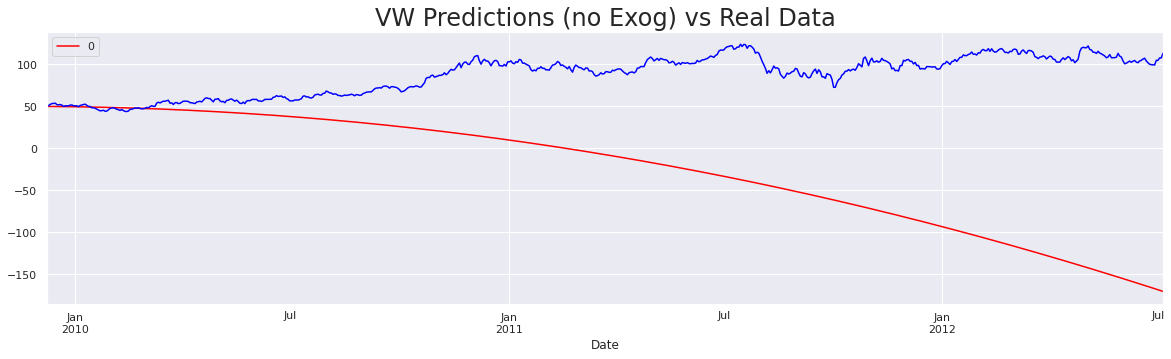

In [80]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

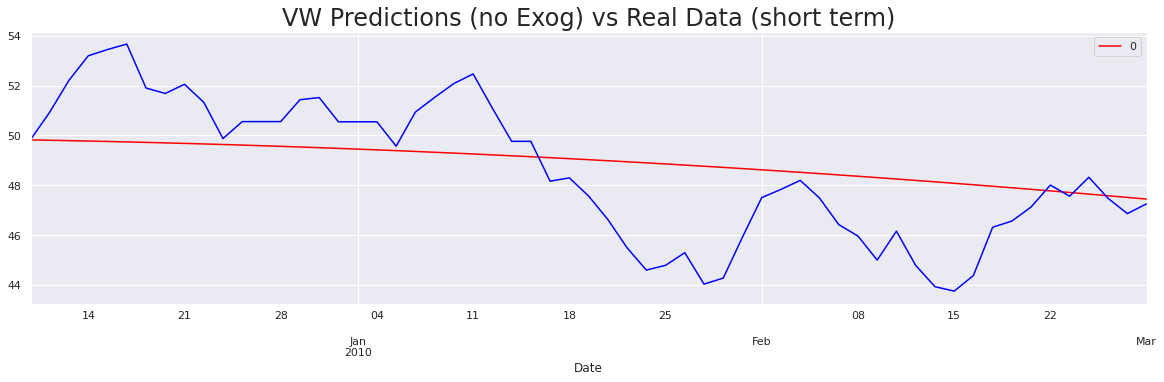

In [81]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

### 7.2. For Volkswagen

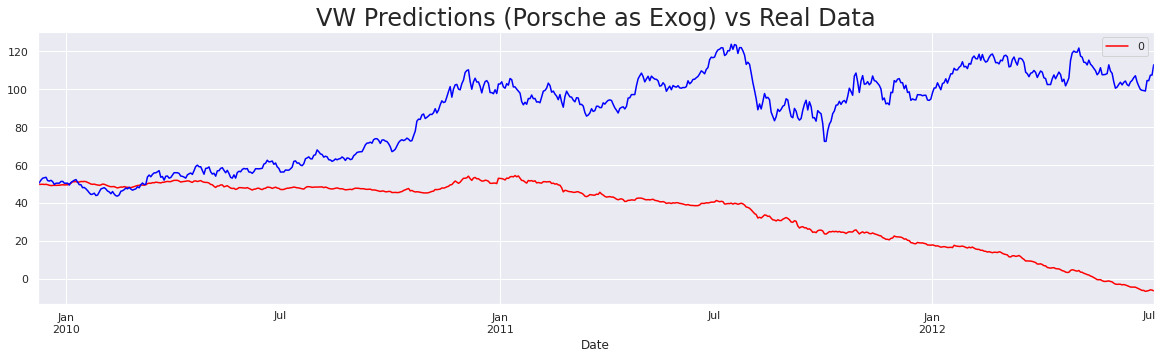

In [82]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 24)
plt.show()

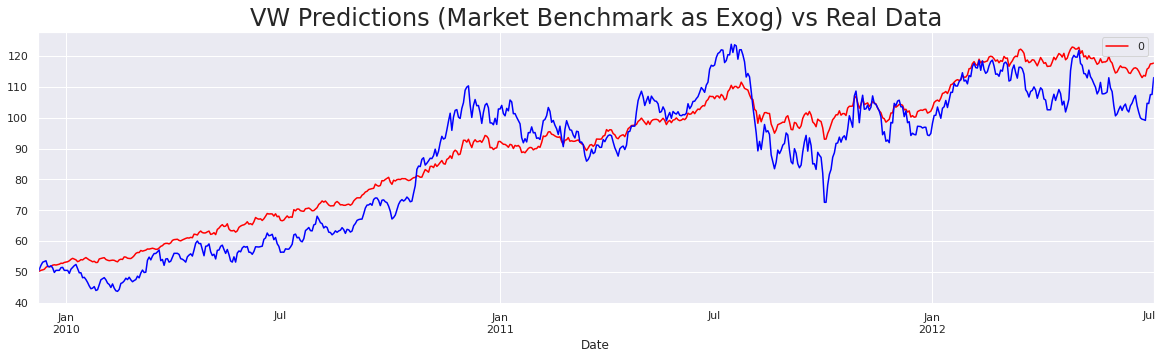

In [83]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

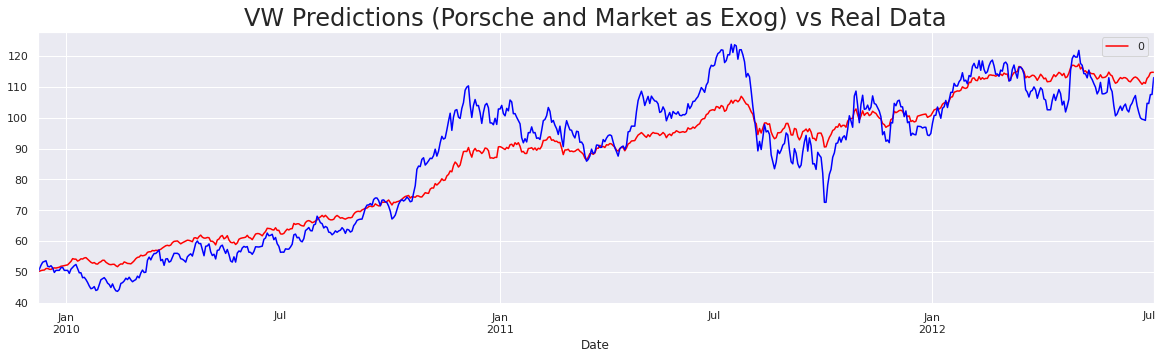

In [84]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por','bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

## 8. Volatility

### 8.1. Volatility of VW for Each Period

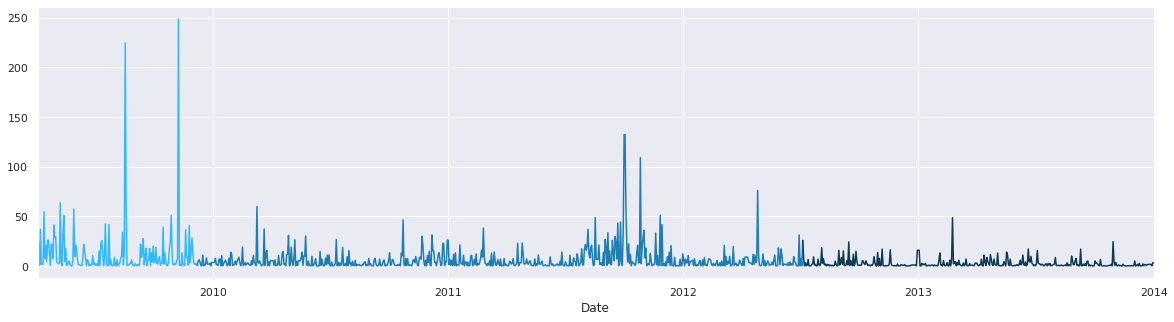

In [85]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### 8.2. Volatility Trends for Each Period

In [86]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 475.8095890013831
Iteration:     10,   Func. Count:     65,   Neg. LLF: 475.02922687645776
Iteration:     15,   Func. Count:     95,   Neg. LLF: 474.9905156418531
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 474.99051558956165
            Iterations: 15
            Function evaluations: 95
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1526.9228181801423
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1526.7316714622107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1526.7316714609651
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     38,   Neg. LLF: 724.5623552188874
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 724.5581359874934
            Iterations: 7
        

In [87]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Mon, Jun 21 2021   Df Residuals:                      177
Time:                        18:21:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6197      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.194e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    1.4724e-12      0.349  4.216e-12      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [88]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Mon, Jun 21 2021   Df Residuals:                      671
Time:                        18:21:22   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.884      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [89]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Mon, Jun 21 2021   Df Residuals:                      389
Time:                        18:21:22   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""